<a href="https://colab.research.google.com/github/VivekKamisetty/cs666student/blob/main/CS666_Assignment_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.9/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['axes', 'clf', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [1]:
!pip install mahotas --no-binary :all:

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 60.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
Skipping wheel build for mahotas, due to binaries being disabled for it.
  Running setup.py install for mahotas ... done


In [41]:
# our imports include sklearn this time
import numpy as np
import mahotas as mh
import os
from sklearn.ensemble import RandomForestClassifier

In [42]:
#Task1
# Run this code to extract the zip file and to create
# the folder structure of normal/, pneumonia/, and covid/ images.
# Each folder contains the first images of the Kaggle datasets.
import zipfile
with zipfile.ZipFile('xray.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

NORMAL_DIR = 'normal/'
PNEUMONIA_DIR = 'pneumonia/'
COVID_DIR = 'covid/'

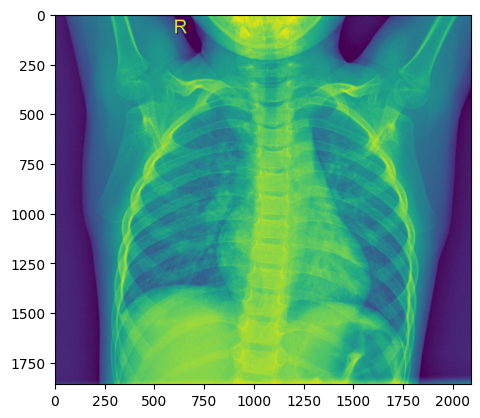

In [43]:
# Here we load the first image from the normal dataset.
img = mh.imread(NORMAL_DIR + 'IM-0115-0001.jpeg')
#TODO: Please display this image and print the dimensions!
imshow(img)

In [44]:
print(np.shape(img))


(1858, 2090)


In [45]:
#Task2
folders = [NORMAL_DIR, PNEUMONIA_DIR, COVID_DIR]
data = [[],[],[]]

for f_index,f in enumerate( folders ):
  all_files = os.listdir( f )

  data[f_index] = np.zeros( (len(all_files), 300, 300), dtype=np.float32)

  for i in range(len(all_files)):
    loaded_image = mh.imread( f + '/' + all_files[i] )
    if loaded_image.ndim > 2:
      loaded_image = mh.colors.rgb2gray(loaded_image[:,:,:3])

    loaded_image = mh.imresize( loaded_image, (300, 300) )
    img_shape = loaded_image.shape

    data[f_index][ i, 0:img_shape[0], 0:img_shape[1] ] = loaded_image

In [46]:
# The two code blocks above perform 3 data wrangling operations.
# Which ones?
# Hint: The first two might be more obvious but the third one happens in the
# last line.
# TODO: Operation 1) Loading image files from multiple directories using os.listdir
# TODO: Operation 2) Resizing the images to a uniform size of (300, 300) using mh.imresize
# TODO: Operation 3) Storing the resized image data in a 3-dimensional numpy array called data, which has shape (num_files, 300, 300) and is separated into three sub-arrays corresponding to the three different directories. The data wrangling operation is to populate this array with the resized image data, with each row corresponding to a single image.

In [47]:
# Now, let's look at the first 5 normal_images and the first 5 pneumonia_images.
# TODO: Please visualize multiple images at once.
# Hint: You can use one of the following answers from StackOverflow for this:
# https://stackoverflow.com/questions/41210823/using-plt-imshow-to-display-multiple-images

In [48]:
# TODO: YOUR CODE

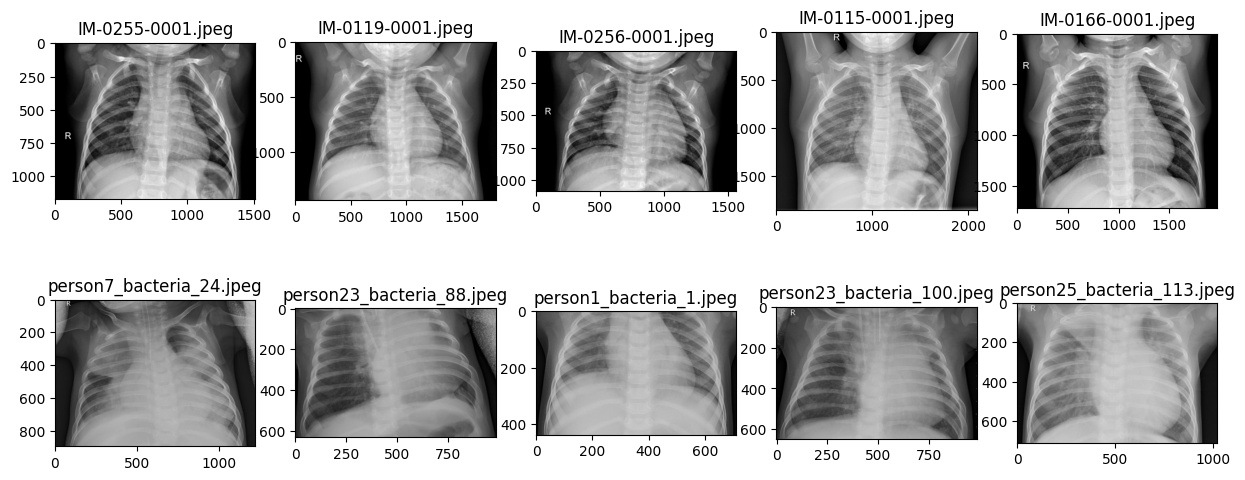

In [49]:

import matplotlib.pyplot as plt

# Load the first 5 images from NORMAL_DIR
normal_files = os.listdir(NORMAL_DIR)[:5]
normal_images = [mh.imread(os.path.join(NORMAL_DIR, f)) for f in normal_files]

# Load the first 5 images from PNEUMONIA_DIR
pneumonia_files = os.listdir(PNEUMONIA_DIR)[:5]
pneumonia_images = [mh.imread(os.path.join(PNEUMONIA_DIR, f)) for f in pneumonia_files]

# Create a figure with two rows and five columns
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))

# Plot the normal images in the first row
for i, ax in enumerate(axes[0]):
    ax.imshow(normal_images[i], cmap='gray')
    ax.set_title(normal_files[i])

# Plot the pneumonia images in the second row
for i, ax in enumerate(axes[1]):
    ax.imshow(pneumonia_images[i], cmap='gray')
    ax.set_title(pneumonia_files[i])

plt.show()

In [50]:
#Task 3
# Any supervised machine learning algorithm requires disjunct sets of
# training and testing data.
#
# For each, we will create a balanced dataset that includes an equal number
# of normal xrays, pneumonia xrays, and covid xrays.
#
# The training data X_train will include 180 images (60 normal, 60 pneumonia, 60 covid).
# The testing data X_test will include the remaining 120 images (40 normal, 40 pneumonia, 40 covid).
#
# Supervised learning means that we tell the algorithm which image is normal
# and which image is pneumonia. For this, we need the y_train vector.
# The vector shall be 0 for a normal image, and 1 for a pneumonia, and 2 for a covid scan.

In [51]:
TRAINING_COUNT = 60

X_train = np.zeros( (TRAINING_COUNT * 3, 300*300 ), dtype=np.float32)
t_pos = 0

for d in data:
  for image in d[0:TRAINING_COUNT]:
    image = image.ravel() # flatten the imvage
    image /= image.max() # normalize the image
    X_train[t_pos] = image
    t_pos += 1

In [52]:
# TODO: Please create the y_train vector with 0 for a normal image, 
# 1 for a pneumonia, and 2 for covid. This needs to a numpy array.
y_train = np.zeros((TRAINING_COUNT * 3), dtype=np.int32)
y_train[TRAINING_COUNT:2*TRAINING_COUNT] = 1
y_train[2*TRAINING_COUNT:] = 2

In [53]:
TESTING_COUNT = 40

X_test = np.zeros( (TESTING_COUNT * 3, 300*300 ), dtype=np.float32)
t_pos = 0

for d in data:
  for image in d[0:TESTING_COUNT]:
    image = image.ravel() # flatten the image
    image /= image.max() # normalize the image
    X_test[t_pos] = image
    t_pos += 1

In [54]:
# TODO: Please create the y_test vector with 0 for a normal image, 
# 1 for a pneumonia, and 2 for covid. This needs to a numpy array.
# Create an empty array for the labels
y_test = np.zeros((TESTING_COUNT * 3,), dtype=np.int32)

# Set the labels for the normal images (first TESTING_COUNT images)
y_test[0:TESTING_COUNT] = 0

# Set the labels for the pneumonia images (next TESTING_COUNT images)
y_test[TESTING_COUNT:TESTING_COUNT*2] = 1

# Set the labels for the COVID-19 images (last TESTING_COUNT images)
y_test[TESTING_COUNT*2:] = 2

In [55]:
#Task 4: Let's train and evaluate the Random Forest! [35 Points]

In [56]:
# Let's shuffle our training data.
p = np.random.permutation(len(X_train))
X_train = X_train[p]
y_train = y_train[p]

In [57]:
# With scikit-learn, we can easily set up a default Random Forest classifier.
clf = RandomForestClassifier()

In [58]:
# Now, we train the classifier with the training data and the training targets.
# We essentially show the classifier an image and tell whether the image is 
# normal or pneumonia or covid.
fitted = clf.fit( X_train, y_train )

In [59]:
# TODO: In just a few sentences, please explain how the Random Forest works.
# It creates decision trees using various samples; then, using a random forest, each tree generates a class prediction, with the class receiving the most votes serving as the model's prediction.

In [60]:
# After training, we can see how well the classifier predicts our testing data.
# The following command will return the classification accuracy.
clf.score( X_test, y_test )

1.0

In [61]:
# TODO: Is the classification accuracy good? And, are you surprised?

In [62]:

covid_images = data[2]
covid_remaining_images = covid_images[100:]

TRAINING_COUNT_REMAIN = 99
X_train_remain = np.zeros((TRAINING_COUNT_REMAIN, 300*300), dtype=np.float32)
train_pos = 0
for d in covid_remaining_images:
    image = image.ravel()
    image /= image.max()
    X_train_remain[train_pos] = image
    train_pos += 1

y_train_remain = np.full((TRAINING_COUNT_REMAIN,), 2, dtype=np.float32)

TESTING_COUNT_REMAIN = 40
X_test_remain = np.zeros((TESTING_COUNT_REMAIN, 300*300), dtype=np.float32)
test_pos = 0
for d in covid_remaining_images[0:TESTING_COUNT_REMAIN]:
    image = image.ravel()
    image /= image.max()
    X_test_remain[test_pos] = image
    test_pos += 1

y_test_remain = np.full((TESTING_COUNT_REMAIN,), 2, dtype=np.float32)

p = np.random.permutation(len(X_train_remain))
X_train_remain = X_train_remain[p]
y_train_remain = y_train_remain[p]

fitted = clf.fit(X_train_remain, y_train_remain)

accuracy = clf.score(X_test_remain, y_test_remain)
print("Classification accuracy on remaining COVID-19 images: {:.2f}%".format(accuracy*100))

Classification accuracy on remaining COVID-19 images: 100.00%
